In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mean = 40
stDev = 20
val = np.random.normal(mean, stDev, 100000)
val = np.clip(val, 5, 95)

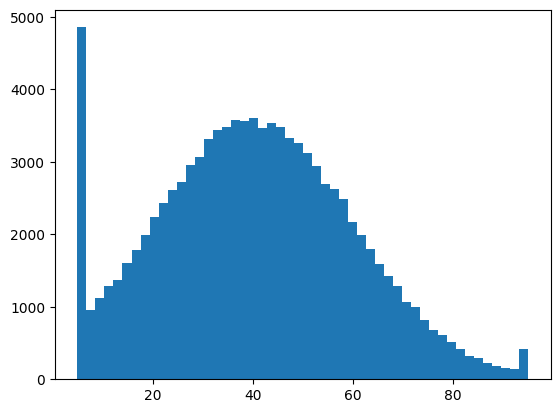

In [3]:
plt.hist(val, bins=50)
plt.show()

In [4]:
min(val), max(val)

(5.0, 95.0)

## 1. Generate Marks

In [5]:
marks = np.random.normal(mean, stDev, (100000, 10))
marks = np.clip(marks, 5, 95)

In [6]:
marks.shape

(100000, 10)

In [7]:
result = np.random.rand(100000)
result = np.array(result > 0.5, dtype='int8')
result.shape

(100000,)

In [8]:
df = pd.DataFrame(marks, columns=[f'SUB-{i+1}' for i in range(10)])
df['Result'] = result
df.sample(5)

,SUB-1,SUB-2,SUB-3,SUB-4,SUB-5,SUB-6,SUB-7,SUB-8,SUB-9,SUB-10,Result
73682,45.629506,49.265946,20.177644,26.166606,25.534356,33.524453,68.589191,24.189372,10.242117,85.269349,1
16863,42.774987,7.415778,15.565941,26.010654,9.012331,35.697313,32.681378,13.264064,13.389169,84.491912,1
46235,20.527360,44.720019,51.821261,43.025424,40.514560,53.843796,38.836474,65.793438,10.310773,42.980609,1
94854,28.185857,78.025094,5.000000,7.111870,17.674281,51.934624,36.702284,45.390064,38.257974,43.145030,0
57511,36.026206,8.886849,41.825031,40.692653,17.926145,26.726915,46.737135,60.359093,5.783695,65.961298,0


In [9]:
df['Result'].value_counts()

Result
1    50019
0    49981
Name: count, dtype: int64

## 2. Plot Histogram

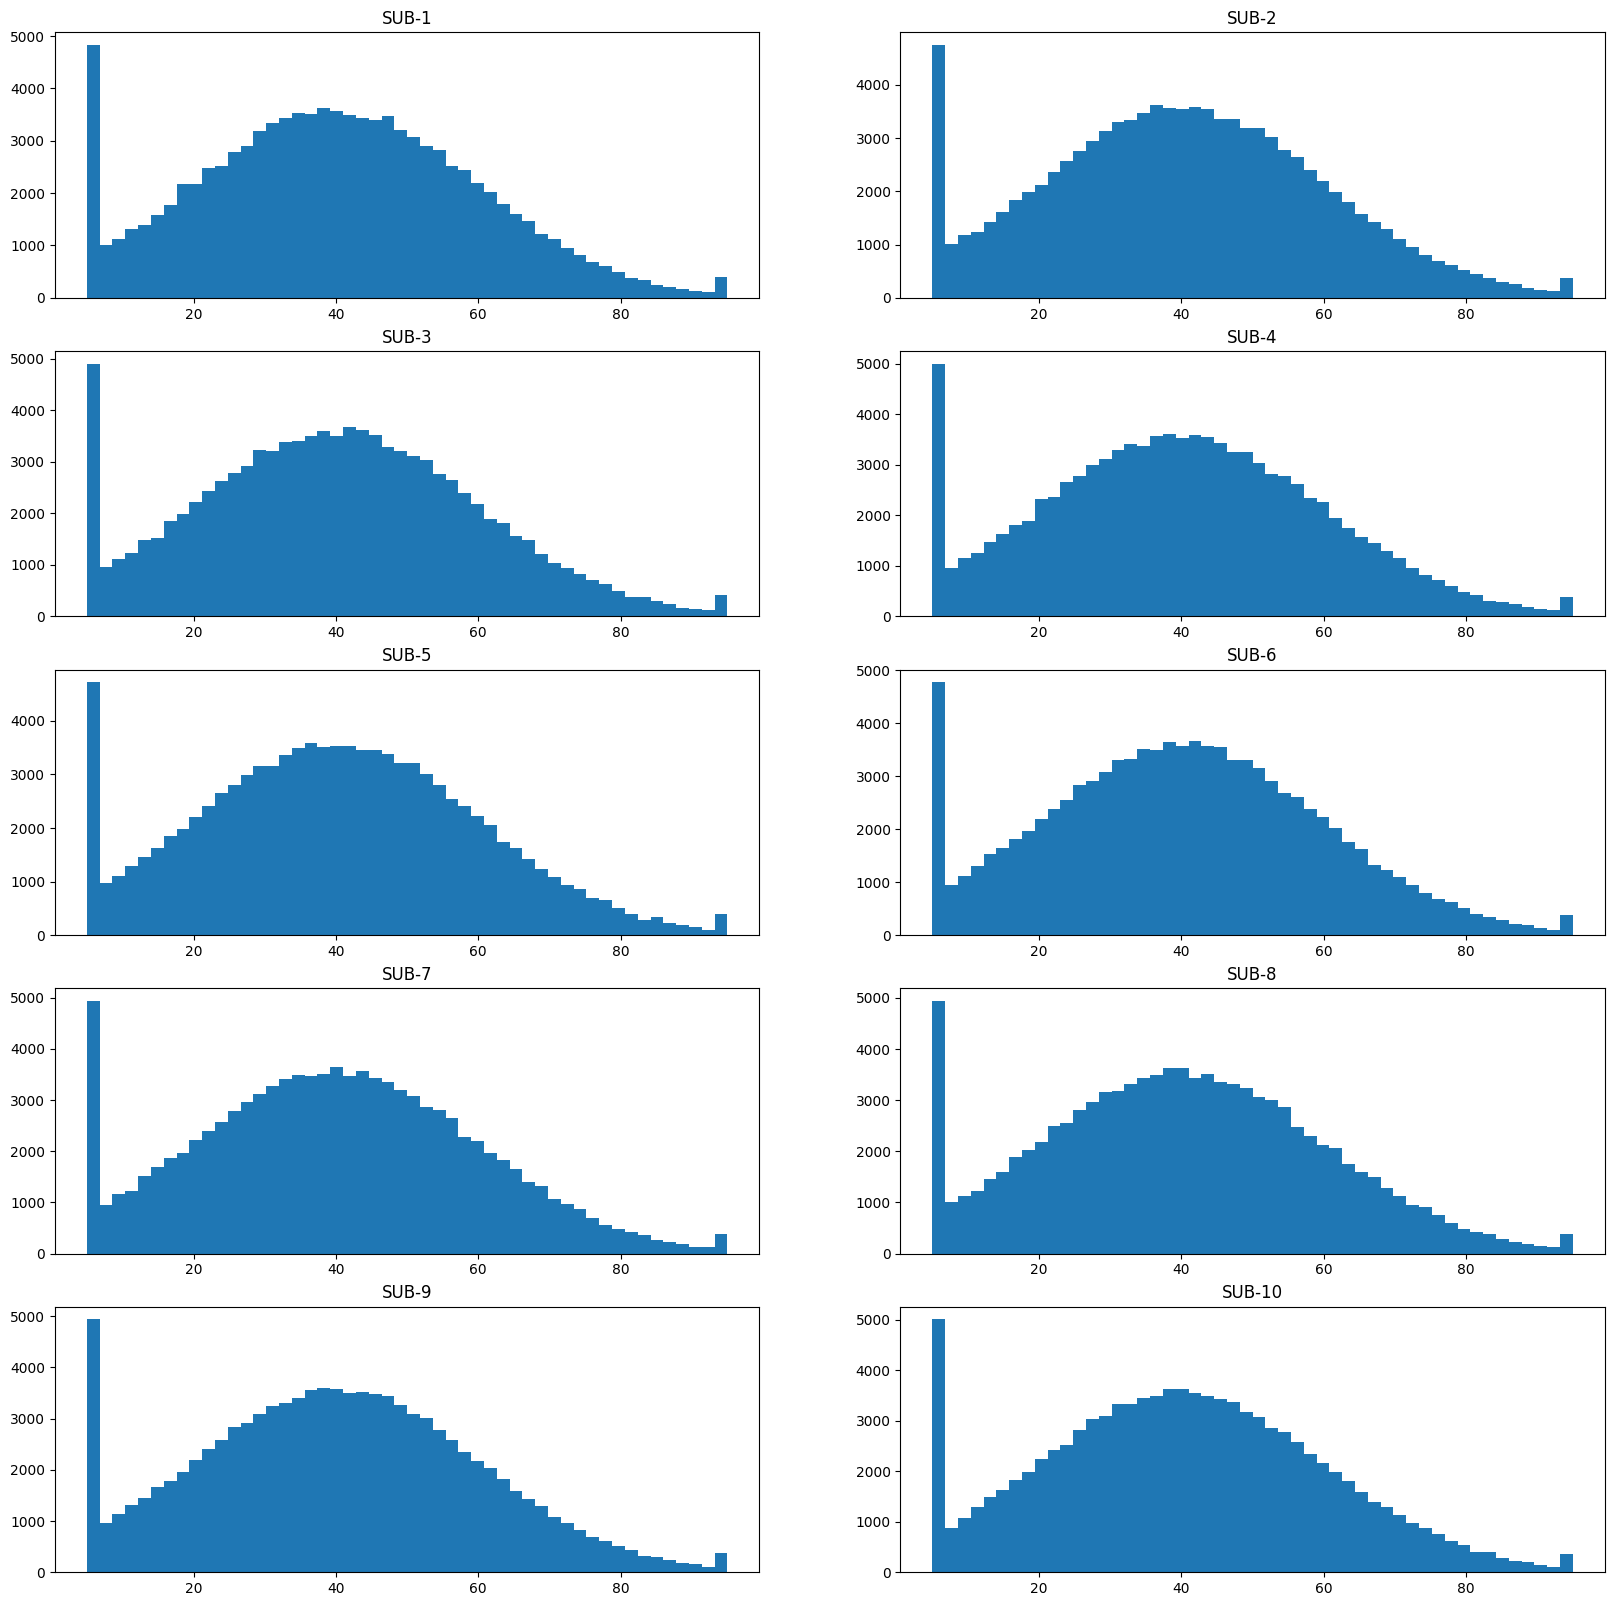

In [10]:
# Histogram for 10 subjects
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.title(f'SUB-{i+1}')
    plt.hist(df[f'SUB-{i+1}'], bins=50)
plt.show()

## 3. ANN Model

In [62]:
# spliting features & label
X = df.iloc[:, :2].values
Y = df.iloc[:, -1].values

# spliting train & test
xTrain, xTest = X[:80000, :], X[80000:, :]
yTrain, yTest = Y[:80000], Y[80000:]

In [12]:
# initialize parameters
def initialize(ldims):
    inputLayer = ldims[0]
    hidden1 = ldims[1]
    hidden2 = ldims[2]
    hidden3 = ldims[3]
    outputLayer = ldims[4]

    params = {}
    params['W0'] = np.random.randn(hidden1, inputLayer)
    params['B0'] = np.random.randn(hidden1)
    params['W1'] = np.random.randn(hidden2, hidden1)
    params['B1'] = np.random.randn(hidden2)
    params['W2'] = np.random.randn(hidden3, hidden2)
    params['B2'] = np.random.randn(hidden3)
    params['W3'] = np.random.randn(outputLayer, hidden3)
    params['B3'] = np.random.randn(outputLayer)

    return params

In [22]:
# activation function
def sigmoid(x, dvt=False):
    x = np.clip(x, -88.72, 88.72)
    z = np.exp(-x)
    if dvt:
        return z / (1 + z)**2
    return 1 / (1 + z)

In [41]:
# forward propagation
def forward(x, p):
    nnState = {}
    nnState['Z1'] = np.dot(p['W0'], x.T)
    nnState['A1'] = sigmoid(nnState['Z1'])
    nnState['Z2'] = np.dot(p['W1'], nnState['A1'])
    nnState['A2'] = sigmoid(nnState['Z2'])
    nnState['Z3'] = np.dot(p['W2'], nnState['A2'])
    nnState['A3'] = sigmoid(nnState['Z3'])
    nnState['Z4'] = np.dot(p['W3'], nnState['A3'])
    nnState['A4'] = sigmoid(nnState['Z4'])
    return nnState

In [42]:
# cost function
def cost(a, y):
    c = np.dot(y, np.log(a).T) + np.dot((1 - y), np.log(1 - a).T)
    return -c/y.shape[0]

In [50]:
# back propagation
def backPropagation(state, params, x, y):
    m = y.shape[0]
    
    dZ4 = state['A4'] - y
    dW4 = 1./m * np.dot(dZ4, state['A3'].T)
    dB4 = 1./m * np.sum(dZ4)

    dZ3 = np.dot(params['W3'].T, dZ4)*sigmoid(state['Z4'], True)
    dW3 = 1./m * np.dot(dZ3, state['A3'].T)
    dB3 = 1./m * np.sum(dZ3)

    dZ2 = np.dot(params['W2'].T, dZ3)*sigmoid(state['Z3'], True)
    dW2 = 1./m * np.dot(dZ2, state['A1'].T)
    dB2 = 1./m * np.sum(dZ2)

    dZ1 = np.dot(params['W1'].T, dZ2)*sigmoid(state['Z2'], True)
    dW1 = 1./m * np.dot(dZ1, x)
    dB1 = 1./m * np.sum(dZ1)

    return dW1, dB1, dW2, dB2, dW3, dB3, dW4, dB4

In [51]:
# prediction
def predict(x, params):
    res = forward(x, params)
    yPred = np.array(res['A4']>0.5, dtype='int8')
    return np.squeeze(yPred)

In [69]:
# main
l = [xTrain.shape[1], 15, 15, 15, 1]
params = initialize(l)
iters = 1000
lr = 0.01
t = []
c = []
a = []
for i in range(iters):
    nn = forward(xTrain, params)
    if i % (iters/10) == 0:
        t.append(i)
        c.append(cost(nn['A4'], yTrain))
        a.append(np.sum(predict(xTrain, params) == yTrain)/yTrain.shape[0])

    dW0, dB0, dW1, dB1, dW2, dB2, dW3, dB3 = backPropagation(nn, params, xTrain, yTrain)
    
    params['W0'] -= lr * dW0
    params['B0'] -= lr * dB0
    params['W1'] -= lr * dW1
    params['B1'] -= lr * dB1
    params['W2'] -= lr * dW2
    params['B2'] -= lr * dB2
    params['W3'] -= lr * dW3
    params['B3'] -= lr * dB3

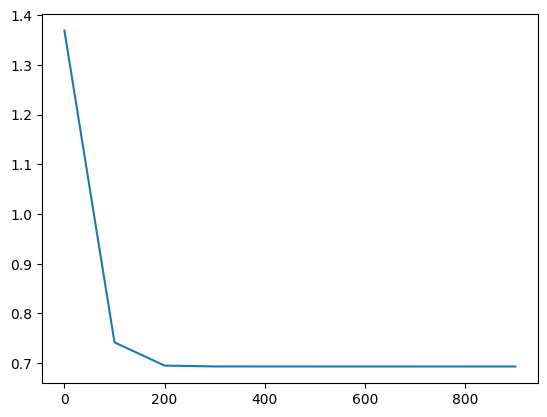

In [70]:
plt.plot(t, c)

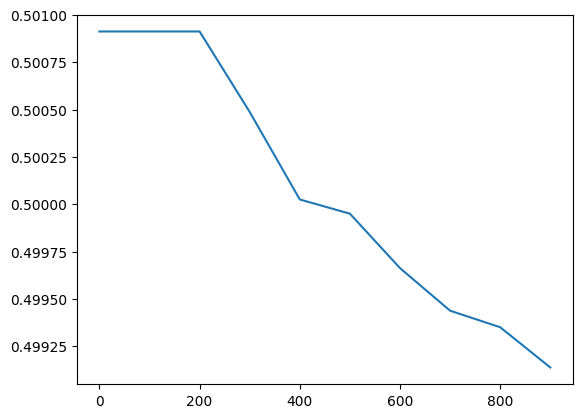

In [71]:
plt.plot(t, a)

In [72]:
# training accuracy
predTrain = predict(xTrain, params)
np.sum(predTrain == yTrain)/yTrain.shape[0]

0.4992625

In [73]:
# testing accuracy
predTest = predict(xTest, params)
np.sum(predTest == yTest)/yTest.shape[0]

0.49715